<a href="https://colab.research.google.com/github/Limontika/DS_Projects/blob/main/module_3/baseline_sf_tripadvisor_rating_sukhov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   


# import

In [102]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from google.colab import drive
drive.mount('/content/drive')

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import warnings
warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (15,7)

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# DATA

In [79]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/module3'
df_train = pd.read_csv(DATA_DIR+'/main_task.xls')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [42]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [ ]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [ ]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [ ]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [80]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [55]:
data.describe()

,Ranking,Number of Reviews,sample,Rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
10976,id_15748,London,"['Fast Food', 'American']",15760.0,$,31.0,"[['Small fast food joint in the station', 'Lik...",/Restaurant_Review-g186338-d4584798-Reviews-Bu...,d4584798,1,3.0
12033,id_2330,Munich,NaN,2346.0,NaN,23.0,[['Very reasonable in terms of pricing and fr....,/Restaurant_Review-g187309-d5519135-Reviews-Be...,d5519135,1,3.5
14716,id_6051,Madrid,['Russian'],6054.0,$$$$,15.0,"[[], []]",/Restaurant_Review-g187514-d1992937-Reviews-19...,d1992937,1,4.0
38540,id_8784,Paris,"['European', 'French', 'Vegetarian Friendly']",8786.0,$$ - $$$,40.0,"[['Come for drinks only', 'Lunch during museum...",/Restaurant_Review-g187147-d8450883-Reviews-Ge...,d8450883,1,3.5
27048,id_465,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",466.0,$,160.0,"[['A truly AMAZING little gem in Milan !', 'Ex...",/Restaurant_Review-g187849-d4008200-Reviews-Pa...,d4008200,1,4.5


In [ ]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Общие функции


Округление предсказанных оценок до кратности 0.5

In [81]:
def round_pred(y_pred):
    return [(round(y / 0.5) * 0.5) for y in y_pred]

# Обработка значений столбцов

## Значения столбцов ID_TA и URL_TA не представляют ценности при дальнейшем анализе, так как это системные данные. Но перед удалением можно попробовать найти дубликаты данных

In [82]:
df_sample = data[data['sample'] == 1]
len(df_sample['ID_TA']) - df_sample['ID_TA'].nunique()

20

20 дубликатов. Посмотрим на данные

In [83]:
ta_ids = df_sample['ID_TA'].value_counts()

non_unique_ta = df_sample[df_sample['ID_TA'].apply(lambda x: (ta_ids[x] > 1))]
non_unique_ta.sort_values(by=['ID_TA'])

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
48946,id_3242,Madrid,NaN,3244.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
23980,id_3239,Madrid,NaN,3241.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
21583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...",3812.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463,1,4.0
14732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...",3806.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463,1,4.0
36551,id_3240,Madrid,NaN,3242.0,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990,1,4.5
36431,id_3238,Madrid,NaN,3240.0,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990,1,4.5
20819,id_2197,Madrid,NaN,2199.0,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719,1,4.5
22628,id_2329,Madrid,NaN,2331.0,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719,1,4.5
39879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3664.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956,1,4.0
26920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3538.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956,1,4.0


Все данные одинковые кроме Ranking. Удалим данные из таблицы где Ranking будет хуже.

In [84]:
items_to_drop = non_unique_ta.sort_values(by=['ID_TA', 'Ranking'], ascending=False).index[0::2]

In [85]:
data.drop(labels=items_to_drop, axis=0, inplace=True)

# и проверяем, чтобы их не осталось
df_sample = data[data['sample'] == 1]
len(df_sample['ID_TA']) - df_sample['ID_TA'].nunique()

0

Теперь можно спокойно удалить данные столбцы

In [86]:
data.drop(columns=['URL_TA', 'ID_TA'], inplace=True)

## Посмотрим на целевой столбец *Rating*

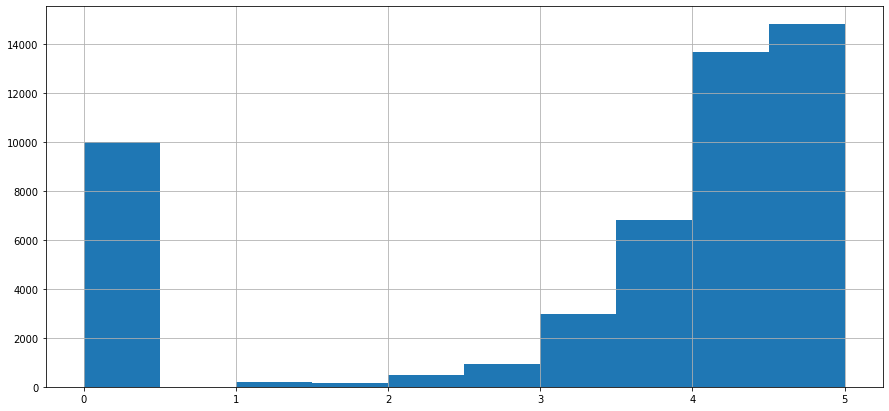

In [87]:
data['Rating'].hist()

Выбросов в данном значении не наблюдается, так же можно заметить, что все значения кратны 0.5, что в свою очередь позволяет сделать вывод, что можно задать функцию, которая будет округлять предсказанные значения до кратности 0.5  
Добавим такую функцию в блок "Общие функции"

## Обработка столбца Restaurant_id


Данный столбец числовой, но в нем присутствует подпись id_. Удалим её.


In [88]:
data['Restaurant_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

Оценим сколько всего уникальных ресторанных сетей

In [89]:
data['Restaurant_id'].value_counts().value_counts()

1     3810
2     2553
3     1846
4     1227
5      809
6      518
7      412
8      381
10     333
9      312
11     254
12     220
13     151
14     129
15      74
16      37
17      18
18       6
19       4
Name: Restaurant_id, dtype: int64

Мы видем что есть сетевые рестораны. Построим распределение

Text(0.5, 0, 'Количество ресторанов в сети')

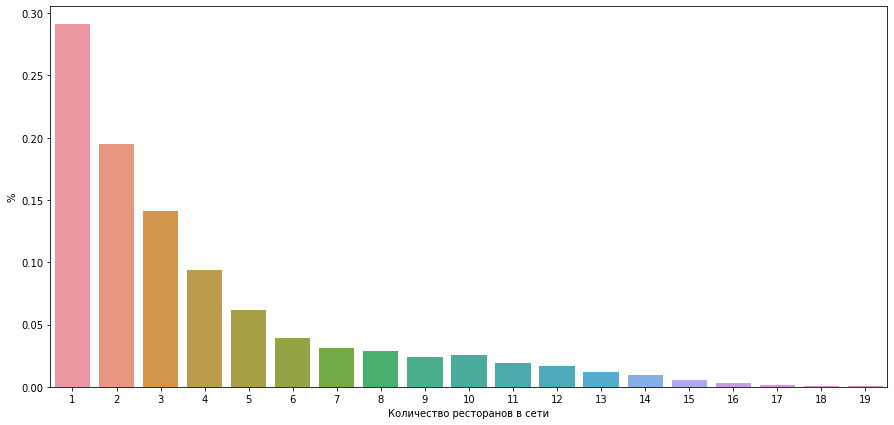

In [90]:
all_id = data['Restaurant_id'].value_counts()
all_restuaran = all_id.value_counts()/len(all_id)
sns.barplot(y=all_restuaran, x=all_restuaran.index)
plt.ylabel('%')
plt.xlabel('Количество ресторанов в сети')

Около 30% не сетевых ресторанов, но так же сетевых ресторанов очень много, максимальное значение достигает в 19 ресторанов в одной сети.

## Обработка столбца Price Range

При первичном анализе в данном столбце были обнаружены пропуски, чтобы их заполнить, нужно разобраться со значением object в данном столбце. Так как изначально предполагается что этот слобец должен быть числовым, но нам пришли только строковые значения. Займемся преобразованием.

In [91]:
data['Price Range'].value_counts()

$$ - $$$    23031
$            7813
$$$$         1782
Name: Price Range, dtype: int64

Нам предоставляются три значения и значение средней цены преобладает, заполним пропуски значеним средней цены.

In [92]:
dic_value_Price = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price_Range'] = data['Price Range'].map(lambda x: dic_value_Price.get(x,x))
data['Price_Range'] = data['Price_Range'].fillna(2)

## Обработка столбца Number of Reviews

Заполним нулями пропуски

In [93]:
data['Number of Reviews'].fillna(0, inplace=True)

Посмотрим на распределение


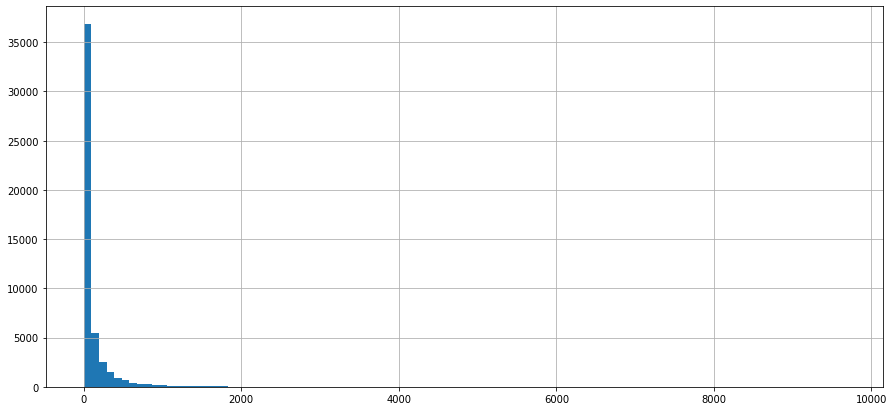

In [94]:
data['Number of Reviews'].hist(bins=100)

Данный график показывает, что данные имеют экспоненциальное распределение. Отрицательных значений не наблюдается, можно идти дальше.

## Обработка столбца Ranking

Выведем распределение

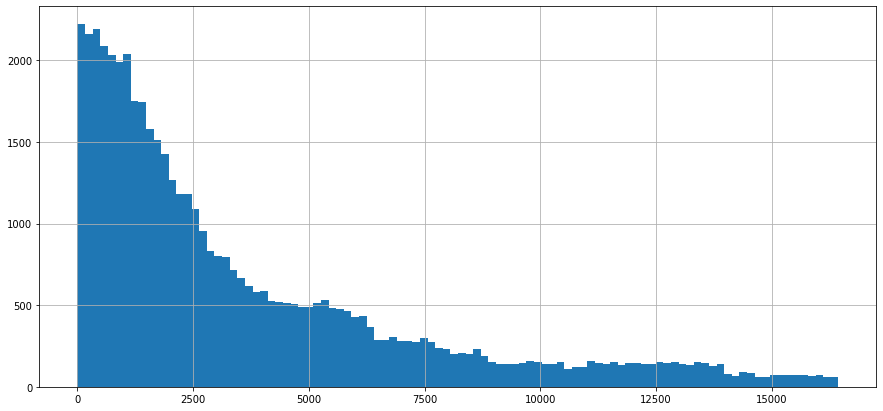

In [95]:
data['Ranking'].hist(bins=100)

Посмотрим на распределение самого крупного города

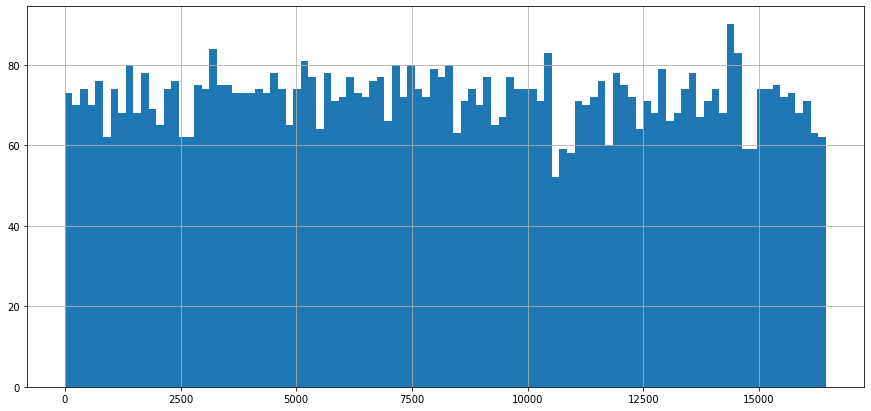

In [96]:
big_city = data['City'].value_counts().index[0]
data['Ranking'][data['City'] == big_city].hist(bins=100)

Оно равномерное.  Взглянем на распределение топ 10 городов

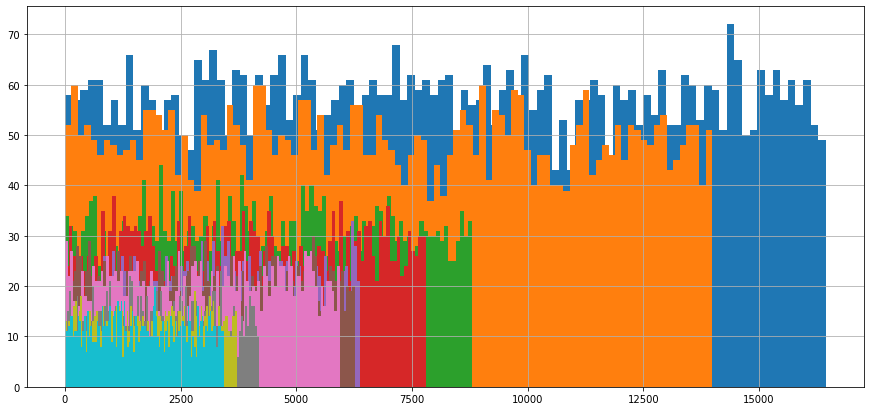

In [97]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

## Обработка столбца City

Получим основные данные из столбца city, для дальнейшей обработки

In [98]:
cities = data['City'].value_counts()
count_cities = len(data['City'])
per_cities = cities / count_cities * 100 

Построим распределение городов


Text(0.5, 0, 'Город')

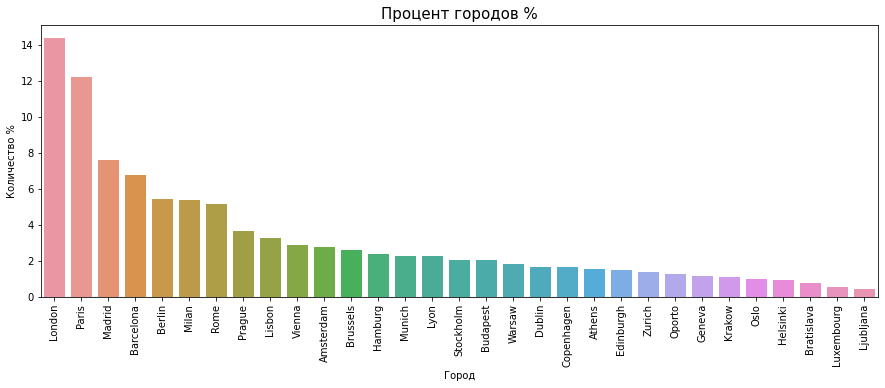

In [99]:
plt.figure(figsize=(15, 5))         
sns.barplot(x=cities.index, y=per_cities)
plt.title('Процент городов %', fontsize=15)
plt.ylabel('Количество %')
plt.xticks(rotation=90)
plt.xlabel('Город')

Города распределены не равномерно, дальше будет преобразование в dummy переменные

## Обработка столбца Cuisine Style

Обработаем значения для удобной работы

In [103]:
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")

# закодируем значения в переменной до их преобразования
le = LabelEncoder()
le.fit(data['Cuisine Style'])
data['code_Cuisine Style'] = le.transform(data['Cuisine Style'])

data['Cuisine Style'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'")

In [104]:
data['Cuisine Style'].head()

0                                           [Bar, Pub]
1    [European, Scandinavian, Gluten Free Options, ...
2                                [Vegetarian Friendly]
3    [Italian, Mediterranean, European, Vegetarian ...
4    [Italian, Mediterranean, European, Seafood, Ve...
Name: Cuisine Style, dtype: object

Построим распределение кухонь

In [111]:
cuisine_style = data['Cuisine Style'].explode().value_counts()

In [112]:
cuisine_sum = cuisine_style.sum()
cuisine_style = cuisine_style.apply(lambda x: x/cuisine_sum)

Text(0.5, 0, 'Кухня')

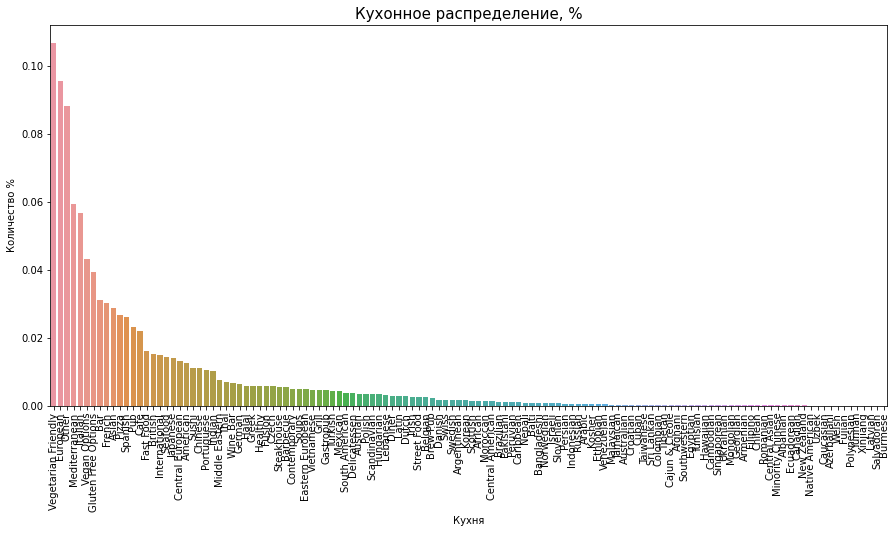

In [113]:
plt.title('Кухонное распределение, %', fontsize=15)
sns.barplot(y=cuisine_style, x=cuisine_style.index)
plt.xticks(rotation=90)
plt.ylabel('Количество %')
plt.xlabel('Кухня')

# Feature Engeneering

Столбец Restaurant_id - это код ресторана или сети. Добавим столбец, указывающий на то, что ресторан сетевой. Значение столбца должно быть тем больше, чем больше ресторанов в этой сети, однако, распределение имеет экспоненциальный вид, поэтому разумнее брать не просто количество ресторанов в сети, а его логарифм

In [114]:
data['IS_NET'] = data['Restaurant_id'].apply(lambda x: math.log(all_id[x]))

Преобразуем ranking в % от общего числа мест в каждом городе, чтобы он зависил только от опций ресторана, а не от популярности города.

In [116]:
def normalize_ranking(row):
  return row['Ranking'] / cities[row['City']]

data['Ranking'] = data.apply(normalize_ranking, axis=1)

Теперь добавим дополнительную информацию по кухням: популярность кухонь - сумму % частоты каждой кухни из предлагаемых рестораном.

In [118]:
def cuisine_rating(x):
    return sum([cuisine_style[c] for c in x])


data['Cuisine Rating'] = data['Cuisine Style'].apply(cuisine_rating)

Превратим столбец reviews из каши в разницу (в днях) между датами самого старого и самого нового обзоров

In [119]:
def parse_review_date(x):
    arr = str(x)[2:-2].split('], [')
    if (len(arr) < 2 or arr[1] == ''):               
        return []

    res = pd.to_datetime(arr[1].split(', '), format='\'%m/%d/%Y\'')
    return [res.min(), res.max()]


now = datetime.now()
data['Review_dates'] = data.Reviews.apply(parse_review_date)
data['Review_dist'] = data.Review_dates.apply(lambda x: (x[1] - x[0]).days if len(x) == 2 else 0)
data['Review_age'] = data.Review_dates.apply(lambda x: (now - x[1]).days if len(x) == 2 else 0)
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,Price_Range,code_Cuisine Style,IS_NET,Cuisine Rating,Review_dates,Review_dist,Review_age
0,0,Paris,"[Bar, Pub]",2.122299,$$ - $$$,4.0,"[[], []]",0,0.0,2.0,1778,2.772589,0.054499,[],0,0
1,1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",0.223158,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,2.0,4076,2.302585,0.288714,"[2017-10-29 00:00:00, 2017-12-05 00:00:00]",37,1216
2,2,Edinburgh,[Vegetarian Friendly],1.087248,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,2.0,10661,2.708050,0.106811,"[2017-12-06 00:00:00, 2017-12-28 00:00:00]",22,1193
3,3,London,"[Italian, Mediterranean, European, Vegetarian ...",0.232031,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,3.0,7110,2.197225,0.358196,"[2017-11-22 00:00:00, 2017-12-06 00:00:00]",14,1215
4,4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",0.097368,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,3.0,7094,2.639057,0.372501,"[2018-01-24 00:00:00, 2018-02-08 00:00:00]",15,1151


перед последним штрихом посмотрим на корреляции между числовыми столбцами, чтобы исключить высококоррелированные.

In [121]:
corr_matrix = data.drop(columns=['Restaurant_id', 'sample']).corr(method='pearson')
corr_matrix

,Ranking,Number of Reviews,Rating,Price_Range,code_Cuisine Style,IS_NET,Cuisine Rating,Review_dist,Review_age
Ranking,1.000000,-0.407948,-0.168661,-0.042870,0.166506,-0.411709,-0.534237,0.109098,-0.061655
Number of Reviews,-0.407948,1.000000,0.011041,0.107735,-0.090932,0.176388,0.413032,-0.087328,0.032736
Rating,-0.168661,0.011041,1.000000,-0.012169,-0.007384,0.340596,0.037270,-0.025965,-0.006942
Price_Range,-0.042870,0.107735,-0.012169,1.000000,0.108344,0.023909,0.107820,-0.035002,-0.056360
code_Cuisine Style,0.166506,-0.090932,-0.007384,0.108344,1.000000,-0.046807,-0.095370,0.019213,-0.070525
IS_NET,-0.411709,0.176388,0.340596,0.023909,-0.046807,1.000000,0.265425,-0.048965,0.007213
Cuisine Rating,-0.534237,0.413032,0.037270,0.107820,-0.095370,0.265425,1.000000,-0.133480,0.036989
Review_dist,0.109098,-0.087328,-0.025965,-0.035002,0.019213,-0.048965,-0.133480,1.000000,0.232338
Review_age,-0.061655,0.032736,-0.006942,-0.056360,-0.070525,0.007213,0.036989,0.232338,1.000000


 чтобы было проще искать - отфильтруем все корреляции больше 0.7 по модулю

In [122]:
corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)].fillna('')

,Ranking,Number of Reviews,Rating,Price_Range,code_Cuisine Style,IS_NET,Cuisine Rating,Review_dist,Review_age
Ranking,1,,,,,,,,
Number of Reviews,,1,,,,,,,
Rating,,,1,,,,,,
Price_Range,,,,1,,,,,
code_Cuisine Style,,,,,1,,,,
IS_NET,,,,,,1,,,
Cuisine Rating,,,,,,,1,,
Review_dist,,,,,,,,1,
Review_age,,,,,,,,,1


Таких нет, можно спокойно проводить обучение модели.

превратим столбец city в dummy-переменные, предварительно уменьшив размерность данных, заменив города с весом меньше 1% на Other

In [124]:
data['City'] = data['City'].apply(lambda x: x if per_cities[x] > 1 else 'Other')
data = pd.get_dummies(data, columns=['City'], prefix='City')
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,Price_Range,code_Cuisine Style,IS_NET,Cuisine Rating,Review_dates,Review_dist,Review_age,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Krakow,City_Lisbon,City_London,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Other,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,0,"[Bar, Pub]",2.122299,$$ - $$$,4.0,"[[], []]",0,0.0,2.0,1778,2.772589,0.054499,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,"[European, Scandinavian, Gluten Free Options, ...",0.223158,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,2.0,4076,2.302585,0.288714,"[2017-10-29 00:00:00, 2017-12-05 00:00:00]",37,1216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2,[Vegetarian Friendly],1.087248,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,2.0,10661,2.708050,0.106811,"[2017-12-06 00:00:00, 2017-12-28 00:00:00]",22,1193,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,"[Italian, Mediterranean, European, Vegetarian ...",0.232031,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",0,0.0,3.0,7110,2.197225,0.358196,"[2017-11-22 00:00:00, 2017-12-06 00:00:00]",14,1215,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,"[Italian, Mediterranean, European, Seafood, Ve...",0.097368,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",0,0.0,3.0,7094,2.639057,0.372501,"[2018-01-24 00:00:00, 2018-02-08 00:00:00]",15,1151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [125]:
# Теперь выделим тестовую часть
train_data = data[data['sample'] == 1].drop(columns=['Restaurant_id', 'Cuisine Style', 'Price Range', 'Reviews', 'Review_dates', 'sample'])
test_data = data[data['sample'] == 1].drop(columns=['Restaurant_id', 'Cuisine Style', 'Price Range', 'Reviews', 'Review_dates', 'sample'])

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [126]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [127]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((39980, 36), (39980, 36), (39980, 35), (31984, 35), (7996, 35))

# Model 
Сам ML

In [128]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [129]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [130]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [131]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20890445222611306


In [139]:
y_pred_rnd = round_pred(y_pred)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rnd))

MAE: 0.17902701350675337


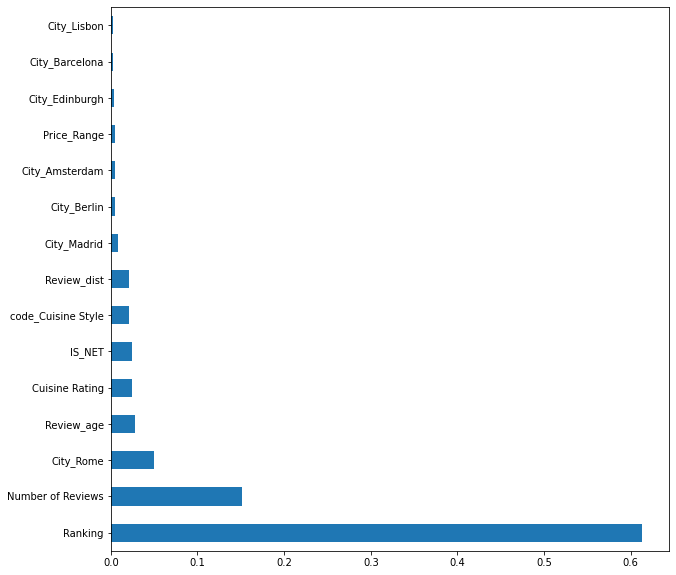

In [140]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [141]:
test_data.sample(10)

,Ranking,Number of Reviews,Price_Range,code_Cuisine Style,IS_NET,Cuisine Rating,Review_dist,Review_age,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Krakow,City_Lisbon,City_London,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Other,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
29205,1.235998,44.0,2.0,9173,2.079442,0.088299,106,1423,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
14384,0.365936,13.0,2.0,7043,2.484907,0.245700,0,1336,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41307,1.978749,230.0,2.0,6756,1.945910,0.162895,14,1173,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47287,1.950925,23.0,2.0,7491,0.000000,0.083330,30,1278,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
23570,1.556007,2.0,2.0,10496,1.098612,0.011051,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32358,0.674559,28.0,2.0,5225,1.945910,0.030249,181,1189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
19714,2.263116,5.0,1.0,9430,1.098612,0.026689,0,1293,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
14417,1.627808,66.0,1.0,9597,2.197225,0.106255,61,1323,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35302,0.706756,405.0,2.0,6571,1.791759,0.197389,662,1739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
19390,1.418115,101.0,2.0,6125,1.609438,0.300039,33,1189,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [142]:
test_data = test_data.drop(['Rating'], axis=1)

KeyError: ignored

In [143]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [144]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


In [145]:
predict_submission

array([3.52 , 4.06 , 4.48 , ..., 4.4  , 4.015, 3.04 ])

In [138]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

ValueError: ignored

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
